- https://mne.tools/stable/auto_tutorials/time-freq/20_sensors_time_frequency.html

- https://github.com/raphaelvallat/yasa/blob/master/notebooks/08_bandpower.ipynb

In [267]:
from pyedflib import highlevel
import pyedflib as plib
import numpy as np
import matplotlib.pyplot as plt

In [148]:
from datetime import datetime
import mne

def align_edf_to_annotation_start(raw, text_start_time_str, time_format="%H:%M:%S", crop=True):
    """
    Align an EDF MNE Raw object with annotation start time from a text file.

    Parameters:
    - raw (mne.io.Raw): The raw EEG data loaded from EDF.
    - text_start_time_str (str): Start time of the text file annotations, e.g. '22:17:13'.
    - time_format (str): Format of the time strings. Default is "%H:%M:%S".
    - crop (bool): Whether to crop the raw file to match annotation start. Default is True.

    Returns:
    - aligned_raw (mne.io.Raw): The cropped (or offset-aware) raw object.
    - offset_sec (float): The time offset in seconds between EDF start and annotation start.
    """

    # Extract EDF measurement start time
    edf_meas_datetime = raw.info['meas_date']
    if isinstance(edf_meas_datetime, tuple):  # Handle MNE version differences
        edf_meas_datetime = edf_meas_datetime[0]

    edf_time_str = edf_meas_datetime.strftime(time_format)
    edf_start_dt = datetime.strptime(edf_time_str, time_format)
    text_start_dt = datetime.strptime(text_start_time_str, time_format)

    # Compute offset in seconds
    offset_sec = (text_start_dt - edf_start_dt).total_seconds()

    if offset_sec < 0:
        raise ValueError(f"Annotation starts before EDF recording by {-offset_sec} seconds.")

    if crop:
        raw = raw.copy().crop(tmin=offset_sec)

    return raw, offset_sec



In [268]:
from mne.io import read_raw_edf
from datetime import datetime
import pandas as pd

# Load EDF
raw = read_raw_edf("data/highAHI/OSAA10002_New.edf", preload=True, verbose=False)
edf_meas_datetime = raw.info['meas_date']
print(f"Original signal starts at {edf_meas_datetime} seconds")


Original signal starts at 2016-08-15 22:14:53+00:00 seconds


In [ ]:
import numpy as np
from mne import create_info

# Step 1: Select only O2, M1, EOG, and EMG channels
eeg_channel = 'O2'
ref_channel = 'M1'

# C3 - M1
# C4 - M2
raw_eeg = raw.copy().pick_channels(["O2", "M1"])

# Step 2: Compute O2 - M1
sfreq = raw_eeg.info['sfreq']
o2_data = raw_eeg.get_data(picks=[eeg_channel])[0]
m1_data = raw_eeg.get_data(picks=[ref_channel])[0]
diff_eeg = o2_data - m1_data  # shape = (n_samples,)


# Step 4: Create a new Raw object with combined EEG
combined_data = np.vstack([diff_eeg])
info = create_info(['EEG_O2-M1'], sfreq=sfreq, ch_types=['eeg'])
combined_data, info

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


(array([[1.75757576e-04, 1.72727273e-04, 1.77777778e-04, ...,
         1.26262626e-05, 5.55555556e-06, 5.55555556e-06]],
       shape=(1, 6951936)),
 <Info | 7 non-empty values
  bads: []
  ch_names: EEG_O2-M1
  chs: 1 EEG
  custom_ref_applied: False
  highpass: 0.0 Hz
  lowpass: 128.0 Hz
  meas_date: unspecified
  nchan: 1
  projs: []
  sfreq: 256.0 Hz
 >)

In [270]:
raw_combined = mne.io.RawArray(combined_data, info)


Creating RawArray with float64 data, n_channels=1, n_times=6951936
    Range : 0 ... 6951935 =      0.000 ... 27155.996 secs
Ready.


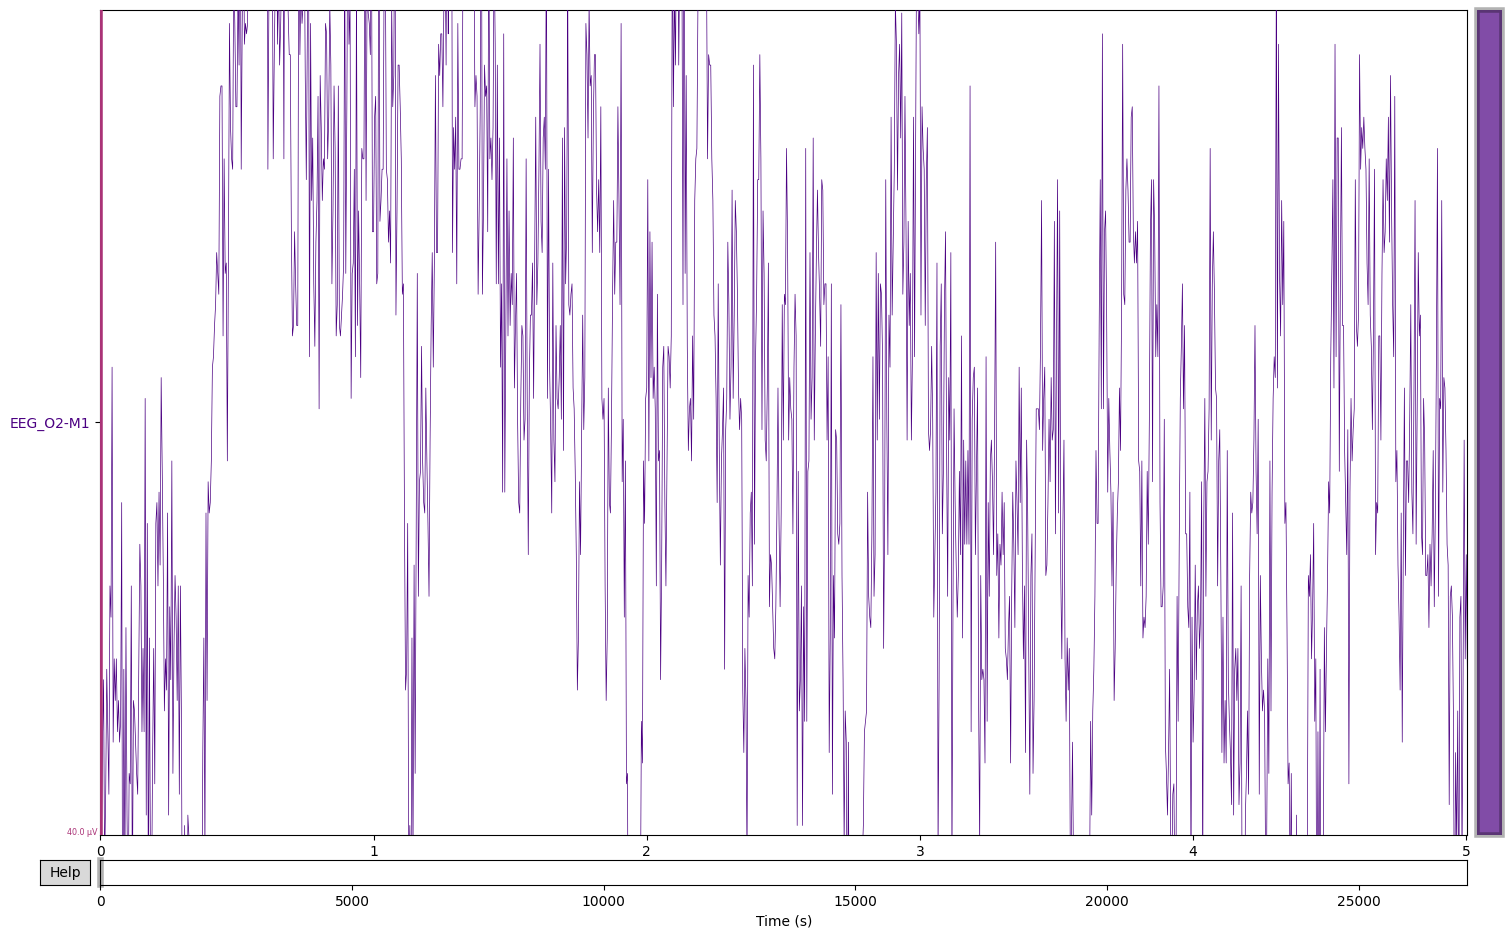

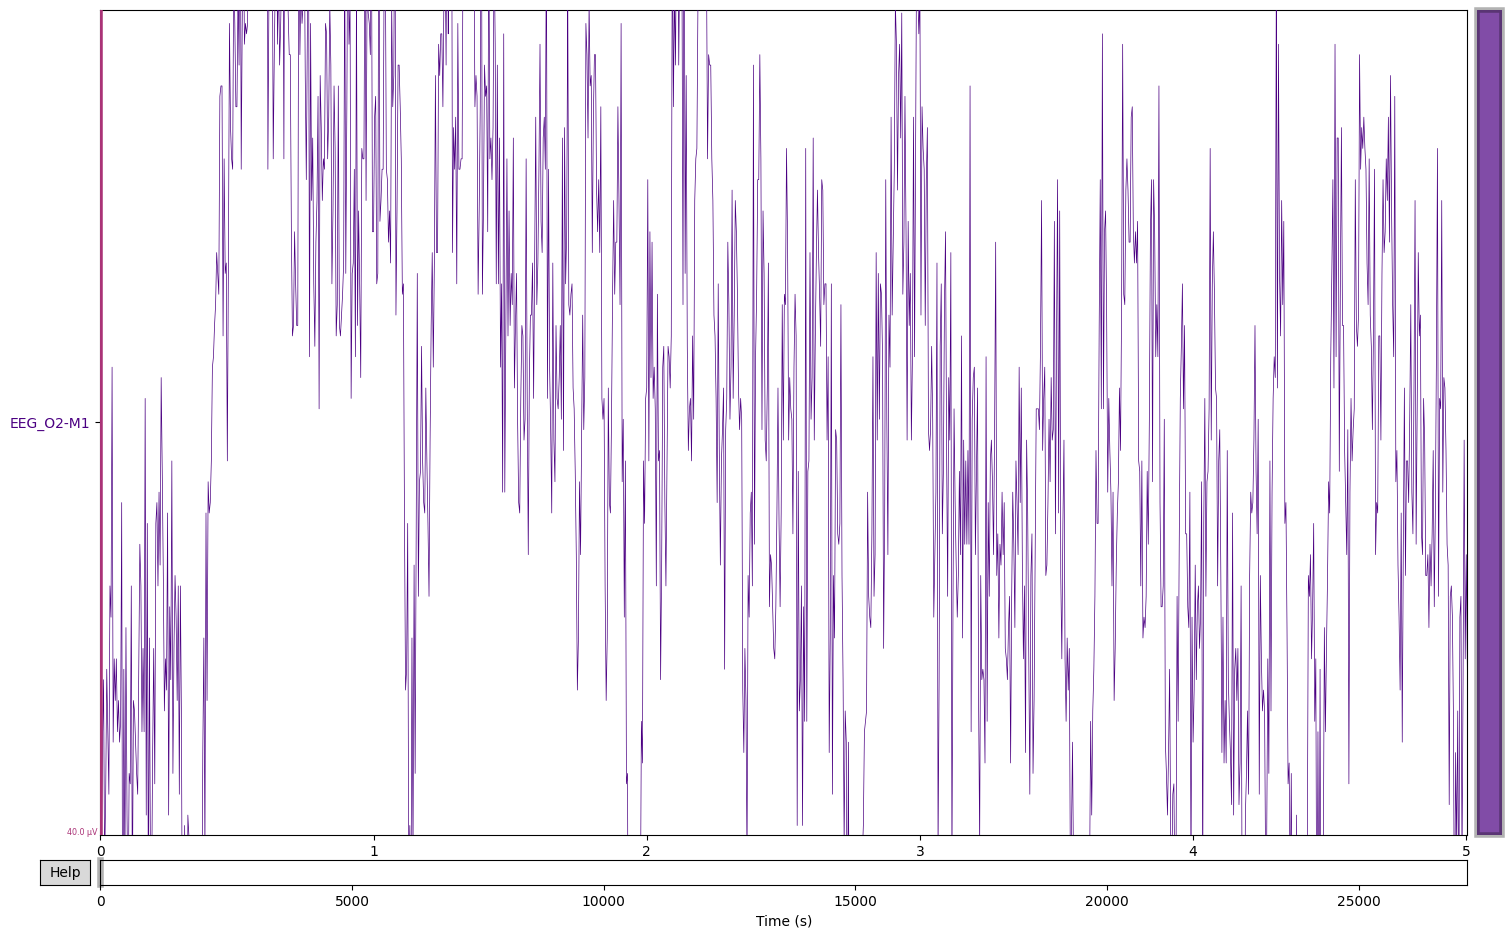

In [242]:
raw_combined.plot(duration=5, start=0, show=True, title='EEG_O2-M1', scalings={'EEG_O2-M1': 100e-6}, color='indigo')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.


/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_38139/2676094094.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_combined.plot_psd()
/Users/archita/osa-ubc/my-env/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


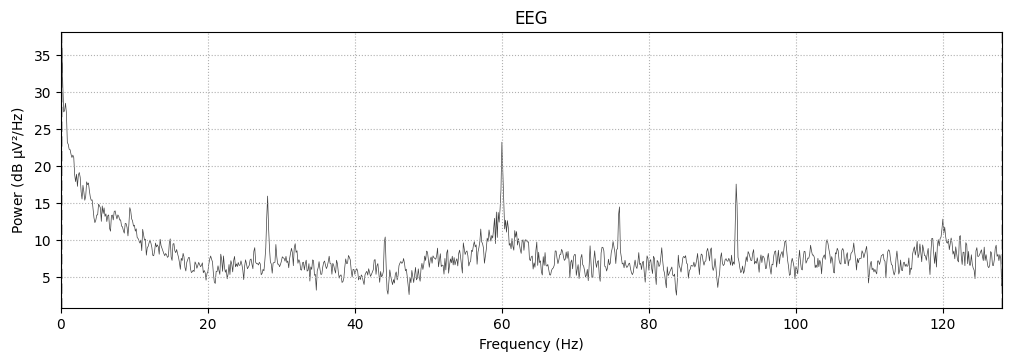

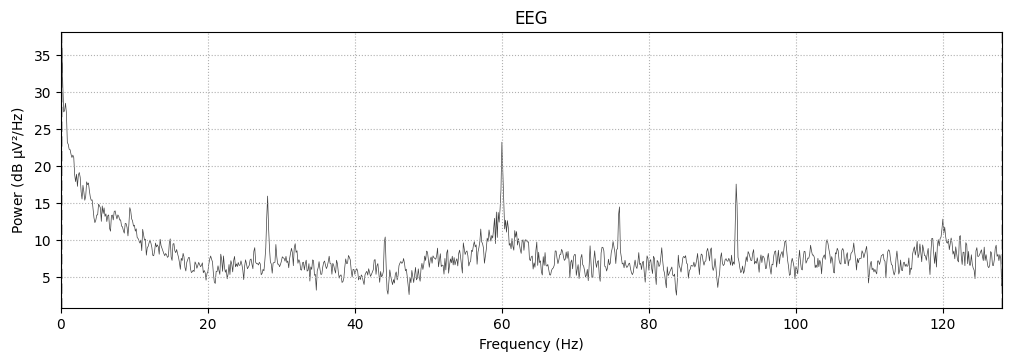

In [245]:
raw_combined.plot_psd()

Power spectral density (PSD) describes how the power of a signal is distributed across different frequencies

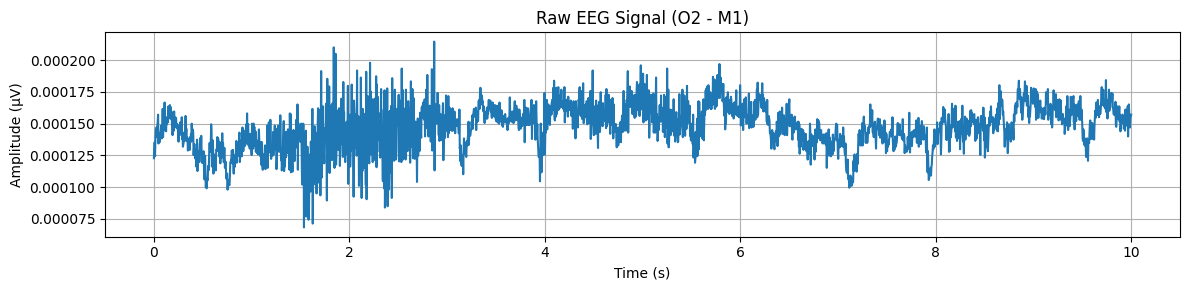

In [247]:
import matplotlib.pyplot as plt

# Plot a raw EEG segment from combined_data
sfreq = info['sfreq']
start_sec = 60
duration = 10
start = int(start_sec * sfreq)
stop = int((start_sec + duration) * sfreq)

plt.figure(figsize=(12, 3))
plt.plot(np.linspace(0, duration, stop - start), combined_data[0, start:stop])
plt.title("Raw EEG Signal (O2 - M1)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.grid(True)
plt.tight_layout()
plt.show()


**Fourier Forward transform**
A Fourier series is the series of sine waves of different frequencies, amplitudes and phases. Fourier analysis is used to deconstruct a signal into its individual sine wave components.
FFTs are great at analyzing vibration when there are a finite number of dominant frequency components.

- What it does: Breaks a signal into its different frequency components.
- A tool that tells you which frequencies are in your signal and how strong each one is at that moment.

**PSD (Power Spectral Density)**
Power spectral densities (PSD) are used to characterize random vibration signals. A PSD is computed by multiplying each frequency bin in an FFT by its complex conjugate which results in the real only spectrum of amplitude in g2.  The key aspect of a PSD which makes it more useful than a FFT for random vibration analysis is that this amplitude value is then normalized to the frequency bin width to get units of g2/Hz.

- What it does: Shows how the power (or energy) of a signal is spread out over different frequencies.
- A smoothed-out and averaged version of FFT that shows how much power is in each frequency range.


**Welch's method is better than Fourier Analysis:**

- Noise reduction: By averaging multiple segments, Welch's method reduces the variance of the power spectrum estimate, making it more reliable for noisy signals like EEG

- Improved resolution: The overlapping segments and windowing help preserve frequency resolution while reducing variance

- Less spectral leakage: Window functions minimize the "leakage" effect that occurs when using finite-length signals with standard FFT

- https://github.com/raphaelvallat/yasa/blob/master/notebooks/08_bandpower.ipynb 

It uses sleeping stages - but how do sleeping stages help in relation to the bandpower - changed frequencies?

- https://raphaelvallat.com/bandpower.html

- Calculates PSD using EEG Signal using Welch's method
- Integrates the power within specific frequency bands (Delta, Theta, Alpha, etc.)

The output columns represent the power in each frequency band:

- Delta: ~0.5-4 Hz (slow waves during deep sleep)
- Theta: ~4-8 Hz (associated with drowsiness)
- Alpha: ~8-13 Hz (relaxed wakefulness)
- Sigma: ~12-16 Hz (sleep spindles)
- Beta: ~13-30 Hz (active thinking, focus)
- Gamma: ~30+ Hz (cognitive processing)
- TotalAbsPow: Total absolute power across all frequencies
- FreqRes: The frequency resolution of the analysis

In [281]:
6881280 - 6878720

2560

In [288]:
import yasa
import pandas as pd
from datetime import datetime, timedelta

# Papers: 2 seconds with 1 second overlap -> 50%

# 6 seconds with 1 second overlap
# more overlap -> more simplified
bandpower_features = []
sfreq = info['sfreq']
window_len = int(sfreq * 10)  # 10s window -> 6s window

eeg_windows = []
# print(combined_data.shape)
# print(window_len)
# # 1s overlap -> change in power due to 1 second 
for i in range(0, combined_data.shape[1] - window_len + 1, window_len):
    # print(i, i+window_len)
    # print(combined_data[:, i:i + window_len])
    eeg_windows.append(combined_data[:, i:i + window_len])  # (n_channels, window_len)

eeg_windows[0][0]


array([0.00017576, 0.00017273, 0.00017778, ..., 0.        , 0.        ,
       0.        ], shape=(2560,))

In [ ]:
for window in eeg_windows:
    bp_per_channel = []
    for ch in window:  # each EEG channel
        bp = yasa.bandpower(ch, sf=sfreq, relative=True)  # relative power in delta, theta, alpha, beta, gamma
        bp_per_channel.append(bp)

    # Average across channels
    mean_bandpower = pd.concat(bp_per_channel).groupby(level=0).mean()
    bandpower_features.append(mean_bandpower)

bp_df = pd.concat(bandpower_features, ignore_index=True)
# Add a time column (start time in seconds for each window)
# Define the signal start time
signal_start_time = datetime.fromisoformat("2016-08-15 22:14:53+00:00")  # or use mne.Info['meas_date']

# For each window (10s each), add i * 10 seconds to the start time
bp_df['Window_Start_Time'] = [signal_start_time + timedelta(seconds=i * 10) for i in range(len(bp_df))]

In [215]:
bp_df['Start_HHMMSS'] = bp_df['Window_Start_Time'].dt.strftime('%H:%M:%S')


In [227]:
bp_df[40:80]

,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative,Window_Start_Time,Start_HHMMSS
40,0.775153,0.133633,0.034096,0.015283,0.025926,0.015909,1.095147e-10,0.25,1.0,2016-08-15 22:21:33+00:00,22:21:33
41,0.709006,0.140078,0.074747,0.025349,0.038356,0.012464,1.231978e-10,0.25,1.0,2016-08-15 22:21:43+00:00,22:21:43
42,0.743302,0.116587,0.055888,0.016333,0.040384,0.027506,1.241641e-10,0.25,1.0,2016-08-15 22:21:53+00:00,22:21:53
43,0.742281,0.108222,0.064154,0.029354,0.036684,0.019304,1.105774e-10,0.25,1.0,2016-08-15 22:22:03+00:00,22:22:03
44,0.736225,0.039229,0.025681,0.020977,0.099614,0.078274,3.390193e-10,0.25,1.0,2016-08-15 22:22:13+00:00,22:22:13
45,0.740437,0.017771,0.084755,0.023154,0.086303,0.047579,8.750330e-10,0.25,1.0,2016-08-15 22:22:23+00:00,22:22:23
46,0.454607,0.056946,0.046140,0.072233,0.242190,0.127883,3.691737e-10,0.25,1.0,2016-08-15 22:22:33+00:00,22:22:33
47,0.233395,0.056099,0.094058,0.181153,0.282727,0.152568,3.073473e-10,0.25,1.0,2016-08-15 22:22:43+00:00,22:22:43
48,0.353299,0.084716,0.290772,0.048878,0.125810,0.096525,8.252734e-11,0.25,1.0,2016-08-15 22:22:53+00:00,22:22:53
49,0.350105,0.054575,0.354590,0.040920,0.121198,0.078611,6.210068e-11,0.25,1.0,2016-08-15 22:23:03+00:00,22:23:03


In [256]:
bp_df_new = bp_df[48:]

In [257]:
bp_df_new

,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative,Window_Start_Time
48,0.353299,0.084716,0.290772,0.048878,0.125810,0.096525,8.252734e-11,0.25,1.0,2016-08-15 22:22:53+00:00
49,0.350105,0.054575,0.354590,0.040920,0.121198,0.078611,6.210068e-11,0.25,1.0,2016-08-15 22:23:03+00:00
50,0.247155,0.066444,0.499360,0.027917,0.093214,0.065909,6.417000e-11,0.25,1.0,2016-08-15 22:23:13+00:00
51,0.354059,0.105969,0.223098,0.069373,0.162833,0.084667,4.133262e-11,0.25,1.0,2016-08-15 22:23:23+00:00
52,0.118186,0.041903,0.747283,0.015630,0.052638,0.024361,1.324671e-10,0.25,1.0,2016-08-15 22:23:33+00:00
...,...,...,...,...,...,...,...,...,...,...
2710,0.584954,0.097088,0.032402,0.082907,0.118319,0.084329,8.745815e-11,0.25,1.0,2016-08-16 05:46:33+00:00
2711,0.693394,0.046640,0.019170,0.032831,0.113093,0.094872,2.506265e-10,0.25,1.0,2016-08-16 05:46:43+00:00
2712,0.549748,0.107757,0.029323,0.039583,0.146618,0.126971,1.005049e-10,0.25,1.0,2016-08-16 05:46:53+00:00
2713,0.593619,0.078667,0.063104,0.031854,0.125769,0.106987,1.174124e-10,0.25,1.0,2016-08-16 05:47:03+00:00


In [115]:
eeg_windows[0]

array([[0.00017576, 0.00017273, 0.00017778, ..., 0.        , 0.        ,
        0.        ]], shape=(1, 2560))

In [162]:
import pandas as pd
from datetime import datetime, timedelta

# Step 1: Load the file without skipping rows
df = pd.read_csv("data/highAHI/OSAA10002 epoch and event list copy.txt", sep='\t', skiprows=12,
                            names=["Epoch", "Event", "Start Time", "Duration"], encoding='latin1')

# Step 1: Convert time
df["Start Time"] = pd.to_datetime(df["Start Time"])

# Step 2: Get Epoch-level base start time
epoch_start = df.groupby("Epoch")["Start Time"].min().reset_index().rename(columns={"Start Time": "Epoch Start Time"})
df = df.merge(epoch_start, on="Epoch")
epoch_start, df

/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_38139/1454084921.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Start Time"] = pd.to_datetime(df["Start Time"])


(     Epoch    Epoch Start Time
 0       17 2025-05-06 22:22:53
 1       18 2025-05-06 22:23:23
 2       19 2025-05-06 22:23:53
 3       20 2025-05-06 22:24:23
 4       21 2025-05-06 22:24:53
 ..     ...                 ...
 885    902 2025-05-06 05:45:23
 886    903 2025-05-06 05:45:53
 887    904 2025-05-06 05:46:23
 888    905 2025-05-06 05:46:53
 889    906 2025-05-06 05:47:23
 
 [890 rows x 2 columns],
       Epoch            Event          Start Time  Duration    Epoch Start Time
 0        17             Wake 2025-05-06 22:22:53   1170.00 2025-05-06 22:22:53
 1        17       Lights Off 2025-05-06 22:23:03  26646.10 2025-05-06 22:22:53
 2        17             Left 2025-05-06 22:23:17    933.35 2025-05-06 22:22:53
 3        18             Wake 2025-05-06 22:23:23       NaN 2025-05-06 22:23:23
 4        19             Wake 2025-05-06 22:23:53       NaN 2025-05-06 22:23:53
 ...     ...              ...                 ...       ...                 ...
 1530    904             Wake

In [163]:
df["Mini Epoch"] = ((df["Start Time"] - df["Epoch Start Time"]).dt.total_seconds() // 10 + 1).astype(int)

### Mini Epoch Generation

```df["Start Time"] - df["Epoch Start Time"]
→ Gives a timedelta object: how many seconds have passed since the start of that epoch.

.dt.total_seconds()
→ Converts the timedelta to a float (number of seconds).

// 10
→ Integer division by 10: determines which 10-second bin it's in:

    0 to <10 seconds → bin 0

    10 to <20 seconds → bin 1

    20 to <30 seconds → bin 2

+ 1
→ Converts bin index to Mini Epoch ID: 1, 2, or 3```

In [164]:
# Step 4: Group by Epoch and Mini Epoch to concatenate multiple events
grouped = df.groupby(["Epoch", "Mini Epoch"]).agg({
    "Event": lambda x: '; '.join(x),
    "Start Time": "min",
    "Duration": "first"
}).reset_index()

grouped[:25]

,Epoch,Mini Epoch,Event,Start Time,Duration
0,17,1,Wake,2025-05-06 22:22:53,1170.00
1,17,2,Lights Off,2025-05-06 22:23:03,26646.10
2,17,3,Left,2025-05-06 22:23:17,933.35
3,18,1,Wake,2025-05-06 22:23:23,NaN
4,19,1,Wake,2025-05-06 22:23:53,NaN
5,20,1,Wake,2025-05-06 22:24:23,NaN
6,21,1,Wake,2025-05-06 22:24:53,NaN
7,22,1,Wake,2025-05-06 22:25:23,NaN
8,23,1,Wake,2025-05-06 22:25:53,NaN
9,24,1,Wake,2025-05-06 22:26:23,NaN


In [165]:
# Step 5: Generate full 3 mini-epochs per Epoch and fill forward
final_rows = []
for epoch in grouped["Epoch"].unique():
    base_time = df[df["Epoch"] == epoch]["Epoch Start Time"].iloc[0]
    mini_map = grouped[grouped["Epoch"] == epoch].set_index("Mini Epoch").to_dict("index")
    
    prev_event, prev_duration = None, None
    for mini in range(1, 4):
        mini_start = base_time + timedelta(seconds=(mini - 1) * 10)
        if mini in mini_map:
            event = mini_map[mini]["Event"]
            duration = mini_map[mini]["Duration"]
        else:
            event, duration = prev_event, prev_duration  # forward fill
        prev_event, prev_duration = event, duration
        final_rows.append({
            "Epoch": epoch,
            "Mini Epoch": mini,
            "Event": event,
            "Start Time": mini_start.strftime("%I:%M:%S %p"),
            "Duration": duration
        })

final_df = pd.DataFrame(final_rows)
final_df['Mini_Epoch_Index'] = range(1, len(final_df) + 1)


In [166]:
final_df["Start Time"].dtype

dtype('O')

In [167]:
final_df.Event.value_counts().head(40)

Event
Wake                                                   1324
Stage 2                                                 328
Both Legs                                               219
Stage 2; Both Legs                                      150
Rem                                                     135
Both Legs w/ Arousal; Arousal w/ PLM                     84
Stage 2; Both Legs w/ Arousal; Arousal w/ PLM            50
Stage 1                                                  36
Hypopnea                                                 25
Desaturation w/ Respiratory                              25
Rem; Desaturation w/ Respiratory                         15
Rem; Hypopnea                                            15
Stage 2; Hypopnea                                        14
Arousal                                                  14
Desaturation                                             13
Stage 2; Desaturation w/ Respiratory                     12
Stage 2; Arousal                  

#### Labelling the Sleeping Stage

In [ ]:
valid_stages = ["Wake", "Stage 1", "Stage 2", "Rem"]

def extract_first_valid_stage(event):
    if isinstance(event, str):
        # Clean messy symbols
        event = event.replace('"', '').replace(',', '')
        parts = [p.strip() for p in event.split(";")]
        
        for part in parts:
            for valid in valid_stages:
                if valid.lower() == part.lower():  # match regardless of case
                    return sleep_stage_to_int(valid)
    return -1

def sleep_stage_to_int(stage):
    if stage == "Wake":
        return 0
    elif stage == "Stage 1":
        return 1
    elif stage == "Stage 2":
        return 2
    elif stage == "Stage 3":
        return 3
    elif stage == "Rem":
        return 4
    else:
        return -1
final_df["Sleeping_stage"] = final_df["Event"].apply(extract_first_valid_stage)


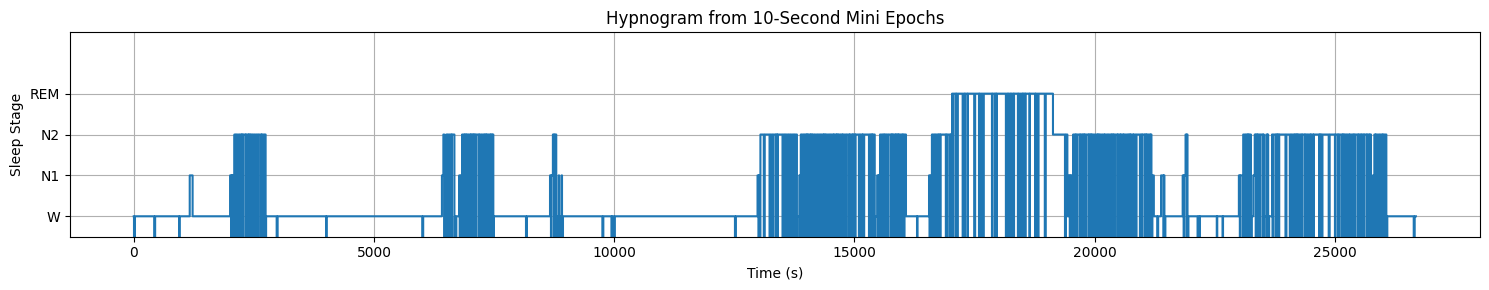

In [169]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get sleep stage sequence as numeric array
y_numeric = final_df["Sleeping_stage"].values

# Step 2: Time axis (each mini-epoch is 10s long)
t = np.arange(len(y_numeric)) * 10  # in seconds

# Step 3: Plot
plt.figure(figsize=(15, 3))
plt.step(t, y_numeric, where='mid', linewidth=1.5)

# Optional: customize y-ticks with labels
plt.yticks([0, 1, 2, 3], ['W', 'N1', 'N2', 'REM'])
plt.ylim(-0.5, 4.5)

plt.xlabel("Time (s)")
plt.ylabel("Sleep Stage")
plt.title("Hypnogram from 10-Second Mini Epochs")
plt.grid(True)
plt.tight_layout()
plt.show()


In [170]:
final_df[final_df["Sleeping_stage"] == -1]["Event"].value_counts()

Event
Both Legs                                                    219
Both Legs w/ Arousal; Arousal w/ PLM                          84
Hypopnea                                                      25
Desaturation w/ Respiratory                                   25
Arousal                                                       14
Desaturation                                                  13
Hypopnea w/ Arousal                                           10
Supine                                                        10
Arousal w/ Respiratory                                         9
Both Legs w/ Arousal                                           9
Arousal w/ PLM                                                 8
Left                                                           6
Arousal w/ Respiratory; Desaturation w/ Respiratory            5
Hypopnea; Desaturation w/ Respiratory                          4
Desaturation w/ Respiratory; Arousal w/ Respiratory            4
Right              

In [171]:
final_df[1700:1730]

,Epoch,Mini Epoch,Event,Start Time,Duration,Mini_Epoch_Index,Sleeping_stage
1700,583,3,Hypopnea w/ Arousal,03:06:13 AM,19.50,1701,-1
1701,584,1,Stage 2,03:06:23 AM,NaN,1702,2
1702,584,2,Desaturation w/ Respiratory; Arousal w/ Respir...,03:06:33 AM,14.09,1703,-1
1703,584,3,Desaturation w/ Respiratory; Arousal w/ Respir...,03:06:43 AM,14.09,1704,-1
1704,585,1,Rem,03:06:53 AM,2100.00,1705,3
1705,585,2,Hypopnea,03:07:03 AM,38.93,1706,-1
1706,585,3,Hypopnea,03:07:13 AM,38.93,1707,-1
1707,586,1,Rem; Desaturation w/ Respiratory,03:07:23 AM,21.09,1708,3
1708,586,2,Rem; Desaturation w/ Respiratory,03:07:33 AM,21.09,1709,3
1709,586,3,Rem; Desaturation w/ Respiratory,03:07:43 AM,21.09,1710,3


#### Labelling Hypopnea or Not

In [172]:
def label_hypopnea_effect(df):
    labels = [0] * len(df)
    i = 0
    while i < len(df):
        if "Hypopnea" in str(df.loc[i, "Event"]):
            labels[i] = 1
            for j in range(1, 3):
                if i + j < len(df):
                    labels[i + j] = -1  # Force overwrite
            i += 3  # Skip next two rows
        else:
            if labels[i] == 0:  # Only set to 0 if not already overwritten
                labels[i] = 0
            i += 1
    return labels

final_df["Hypopnea_Label"] = label_hypopnea_effect(final_df)
final_df[1740:1800]

,Epoch,Mini Epoch,Event,Start Time,Duration,Mini_Epoch_Index,Sleeping_stage,Hypopnea_Label
1740,597,1,Rem,03:12:53 AM,NaN,1741,3,0
1741,597,2,Rem,03:13:03 AM,NaN,1742,3,0
1742,597,3,Rem,03:13:13 AM,NaN,1743,3,0
1743,598,1,Rem,03:13:23 AM,NaN,1744,3,0
1744,598,2,Rem,03:13:33 AM,NaN,1745,3,0
1745,598,3,Rem,03:13:43 AM,NaN,1746,3,0
1746,599,1,Rem,03:13:53 AM,NaN,1747,3,0
1747,599,2,Rem,03:14:03 AM,NaN,1748,3,0
1748,599,3,Rem,03:14:13 AM,NaN,1749,3,0
1749,600,1,Rem,03:14:23 AM,NaN,1750,3,0


### Event Labeling Cases

pre-pre-event -> 2
pre-event -> 1
main-event -> 0
null -> -1


**Case 1**

Index 0: Value = 0 → Label: pre-pre-event  
Index 1: Value = 0 → Label: pre-event  
Index 2: Value = 1 → Label: main-event  

**Case 2**

Index 0: Value = -1 → Label: null  
Index 1: Value = -1 → Label: null  
Index 2: Value = 1  → Label: null  

**Case 3**

Index 0: Value = -1 → Label: null  
Index 1: Value = 0  → Label: pre-event  
Index 2: Value = 1  → Label: main-event  


In [195]:
def label_event_codes(values):
    labels = [-1] * len(values)  # default to 'null' = -1

    for i in range(len(values)):
        if values[i] == 1:
            if i - 1 >= 0 and values[i - 1] != -1:
                labels[i] = "M"  # main-event
                if values[i - 1] == 0:
                    labels[i - 1] = "P"  # pre-event
                    if i - 2 >= 0 and values[i - 2] == 0:
                        labels[i - 2] = "PP"  # pre-pre-event
            else:
                labels[i] = -1  # null if invalid lead-in
    return labels

In [196]:
case1 = [0, 0, 1]
case2 = [-1, -1, 1]
case3 = [-1, 0, 1]

print("Case 1:", label_event_codes(case1))  # [2, 1, 0]
print("Case 2:", label_event_codes(case2))  # [-1, -1, -1]
print("Case 3:", label_event_codes(case3))  # [-1, 1, 0]


Case 1: ['PP', 'P', 'M']
Case 2: [-1, -1, -1]
Case 3: [-1, 'P', 'M']


In [197]:
final_df["Hypopnea_Label_Encode"] = label_event_codes(final_df["Hypopnea_Label"].tolist())

In [198]:
final_df[final_df["Hypopnea_Label"] == 1]["Event"].value_counts()

Event
Hypopnea                                                              16
Hypopnea w/ Arousal                                                    8
Rem; Hypopnea                                                          6
Stage 2; Hypopnea                                                      6
Stage 2; Hypopnea w/ Arousal                                           3
Hypopnea; Desaturation w/ Respiratory                                  3
Stage 1; Hypopnea w/ Arousal                                           3
Arousal w/ PLM; Hypopnea                                               2
Arousal; Hypopnea w/ Arousal                                           1
Stage 2; Both Legs; Hypopnea                                           1
Arousal; Hypopnea                                                      1
Stage 2; Arousal w/ Respiratory; Hypopnea                              1
Stage 2; Both Legs w/ Arousal; Arousal w/ PLM; Hypopnea w/ Arousal     1
Hypopnea w/ Arousal; Desaturation w/ Respirat

In [199]:
final_df.shape

(2670, 9)

In [200]:
final_df[1690:1740]

,Epoch,Mini Epoch,Event,Start Time,Duration,Mini_Epoch_Index,Sleeping_stage,Hypopnea_Label,Hypopnea_Label_Encode
1690,580,2,Stage 2; Both Legs w/ Arousal; Arousal w/ PLM,03:04:33 AM,2.01,1691,2,0,P
1691,580,3,Hypopnea,03:04:43 AM,13.85,1692,-1,1,M
1692,581,1,Stage 2,03:04:53 AM,NaN,1693,2,-1,-1
1693,581,2,Desaturation w/ Respiratory,03:05:03 AM,57.09,1694,-1,-1,-1
1694,581,3,Desaturation w/ Respiratory,03:05:13 AM,57.09,1695,-1,0,-1
1695,582,1,Stage 2,03:05:23 AM,NaN,1696,2,0,-1
1696,582,2,Stage 2,03:05:33 AM,NaN,1697,2,0,-1
1697,582,3,Stage 2,03:05:43 AM,NaN,1698,2,0,-1
1698,583,1,Stage 2,03:05:53 AM,NaN,1699,2,0,PP
1699,583,2,Stage 2,03:06:03 AM,NaN,1700,2,0,P


In [231]:
final_df.tail()

,Epoch,Mini Epoch,Event,Start Time,Duration,Mini_Epoch_Index,Sleeping_stage,Hypopnea_Label,Hypopnea_Label_Encode
2665,905,2,Lights On,05:47:03 AM,24.06,2666,-1,0,-1
2666,905,3,wants to get up,05:47:13 AM,NaN,2667,-1,0,-1
2667,906,1,Wake,05:47:23 AM,NaN,2668,0,0,-1
2668,906,2,Wake,05:47:33 AM,NaN,2669,0,0,-1
2669,906,3,Wake,05:47:43 AM,NaN,2670,0,0,-1


In [233]:
final_df_new = final_df[:-3]
final_df_new

,Epoch,Mini Epoch,Event,Start Time,Duration,Mini_Epoch_Index,Sleeping_stage,Hypopnea_Label,Hypopnea_Label_Encode
0,17,1,Wake,10:22:53 PM,1170.00,1,0,0,-1
1,17,2,Lights Off,10:23:03 PM,26646.10,2,-1,0,-1
2,17,3,Left,10:23:13 PM,933.35,3,-1,0,-1
3,18,1,Wake,10:23:23 PM,NaN,4,0,0,-1
4,18,2,Wake,10:23:33 PM,NaN,5,0,0,-1
...,...,...,...,...,...,...,...,...,...
2662,904,2,Wake,05:46:33 AM,NaN,2663,0,0,-1
2663,904,3,Wake,05:46:43 AM,NaN,2664,0,0,-1
2664,905,1,Wake,05:46:53 AM,NaN,2665,0,0,-1
2665,905,2,Lights On,05:47:03 AM,24.06,2666,-1,0,-1


In [258]:
bp_df_new

,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative,Window_Start_Time
48,0.353299,0.084716,0.290772,0.048878,0.125810,0.096525,8.252734e-11,0.25,1.0,2016-08-15 22:22:53+00:00
49,0.350105,0.054575,0.354590,0.040920,0.121198,0.078611,6.210068e-11,0.25,1.0,2016-08-15 22:23:03+00:00
50,0.247155,0.066444,0.499360,0.027917,0.093214,0.065909,6.417000e-11,0.25,1.0,2016-08-15 22:23:13+00:00
51,0.354059,0.105969,0.223098,0.069373,0.162833,0.084667,4.133262e-11,0.25,1.0,2016-08-15 22:23:23+00:00
52,0.118186,0.041903,0.747283,0.015630,0.052638,0.024361,1.324671e-10,0.25,1.0,2016-08-15 22:23:33+00:00
...,...,...,...,...,...,...,...,...,...,...
2710,0.584954,0.097088,0.032402,0.082907,0.118319,0.084329,8.745815e-11,0.25,1.0,2016-08-16 05:46:33+00:00
2711,0.693394,0.046640,0.019170,0.032831,0.113093,0.094872,2.506265e-10,0.25,1.0,2016-08-16 05:46:43+00:00
2712,0.549748,0.107757,0.029323,0.039583,0.146618,0.126971,1.005049e-10,0.25,1.0,2016-08-16 05:46:53+00:00
2713,0.593619,0.078667,0.063104,0.031854,0.125769,0.106987,1.174124e-10,0.25,1.0,2016-08-16 05:47:03+00:00


In [263]:
# # Convert bp_df_new's datetime to just time (in datetime.time format)
# bp_df_new['Window_Start_Time'] = pd.to_datetime(bp_df_new['Window_Start_Time']).dt.time

# # Convert final_df_new's 12-hour format time to datetime.time
# final_df_new['Start Time'] = pd.to_datetime(final_df_new['Start Time'], format='%I:%M:%S %p').dt.time

# Now you can merge on time
merged_df = pd.merge(final_df_new, bp_df_new, left_on='Start Time', right_on='Window_Start_Time')

In [264]:
merged_df

,Epoch,Mini Epoch,Event,Start Time,Duration,Mini_Epoch_Index,Sleeping_stage,Hypopnea_Label,Hypopnea_Label_Encode,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative,Window_Start_Time
0,17,1,Wake,22:22:53,1170.00,1,0,0,-1,0.353299,0.084716,0.290772,0.048878,0.125810,0.096525,8.252734e-11,0.25,1.0,22:22:53
1,17,2,Lights Off,22:23:03,26646.10,2,-1,0,-1,0.350105,0.054575,0.354590,0.040920,0.121198,0.078611,6.210068e-11,0.25,1.0,22:23:03
2,17,3,Left,22:23:13,933.35,3,-1,0,-1,0.247155,0.066444,0.499360,0.027917,0.093214,0.065909,6.417000e-11,0.25,1.0,22:23:13
3,18,1,Wake,22:23:23,NaN,4,0,0,-1,0.354059,0.105969,0.223098,0.069373,0.162833,0.084667,4.133262e-11,0.25,1.0,22:23:23
4,18,2,Wake,22:23:33,NaN,5,0,0,-1,0.118186,0.041903,0.747283,0.015630,0.052638,0.024361,1.324671e-10,0.25,1.0,22:23:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2662,904,2,Wake,05:46:33,NaN,2663,0,0,-1,0.584954,0.097088,0.032402,0.082907,0.118319,0.084329,8.745815e-11,0.25,1.0,05:46:33
2663,904,3,Wake,05:46:43,NaN,2664,0,0,-1,0.693394,0.046640,0.019170,0.032831,0.113093,0.094872,2.506265e-10,0.25,1.0,05:46:43
2664,905,1,Wake,05:46:53,NaN,2665,0,0,-1,0.549748,0.107757,0.029323,0.039583,0.146618,0.126971,1.005049e-10,0.25,1.0,05:46:53
2665,905,2,Lights On,05:47:03,24.06,2666,-1,0,-1,0.593619,0.078667,0.063104,0.031854,0.125769,0.106987,1.174124e-10,0.25,1.0,05:47:03


In [265]:
merged_df.drop(columns=['Window_Start_Time', 'Duration', 'FreqRes', 'Relative'], inplace=True)

In [266]:
merged_df.to_csv("data/highAHI/OSAA10002_merged.csv", index=False)